In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm
from utils import DensityMetric, Poly2, Spline, connecting_geodesic

In [2]:
# Parameters
num_points = 1000
r_inner = 0.7  # Inner radius (hole radius)
r_outer = 1.0  # Outer radius

# Function to generate circular distribution with a hole
def generate_annular_points(num_points, r_inner, r_outer):
    points = []
    for _ in range(num_points):
        # Generate random radius within the annular region
        r = np.sqrt(np.random.uniform(r_inner**2, r_outer**2))
        # Generate random angle
        theta = np.random.uniform(0, 2 * np.pi)
        # Convert polar to Cartesian coordinates
        x = r * np.cos(theta)
        y = r * np.sin(theta)
        points.append((x, y))
    return torch.tensor(points, dtype=torch.float32)

# Function to generate spherical distribution with a hole in 3D
def generate_annular_points_3d(num_points, r_inner, r_outer):
    points = []
    for _ in range(num_points):
        # Generate random radius within the spherical shell
        r = np.cbrt(np.random.uniform(r_inner**3, r_outer**3))
        # Generate random angles for spherical coordinates
        theta = np.random.uniform(0, 2 * np.pi)  # Azimuthal angle
        phi = np.arccos(np.random.uniform(-1, 1))  # Polar angle
        # Convert spherical to Cartesian coordinates
        x = r * np.sin(phi) * np.cos(theta)
        y = r * np.sin(phi) * np.sin(theta)
        z = r * np.cos(phi)
        points.append((x, y, z))
    return torch.tensor(points, dtype=torch.float16)

In [3]:
# Generate points
data = generate_annular_points(num_points, r_inner, r_outer)
data_3d = generate_annular_points_3d(num_points, r_inner, r_outer)

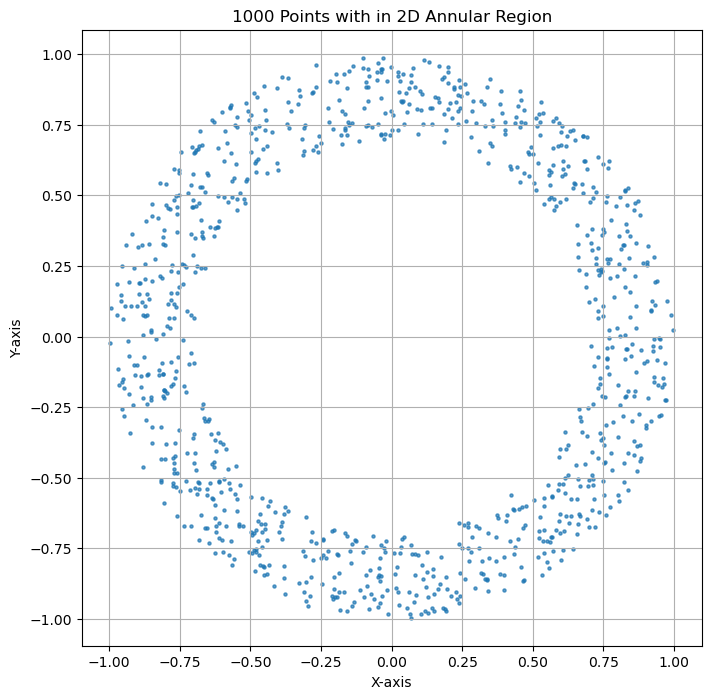

In [4]:
# Plotting the points
plt.figure(figsize=(8, 8))
plt.scatter(data[:, 0], data[:, 1], s=5, alpha=0.7)
plt.gca().set_aspect('equal', adjustable='box')
plt.title(f'{num_points} Points with in 2D Annular Region')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.grid(True)
plt.show()

In [26]:
dm = DensityMetric(data, 0.05)
dm_energy = lambda _model, _curve: _model.curve_energy(_curve.points())

In [24]:
num_curves = 30
N, D = data.shape
curve_indices = torch.randint(data.shape[0], (num_curves, 2))  # (num_curves) x 2

0.9432266354560852


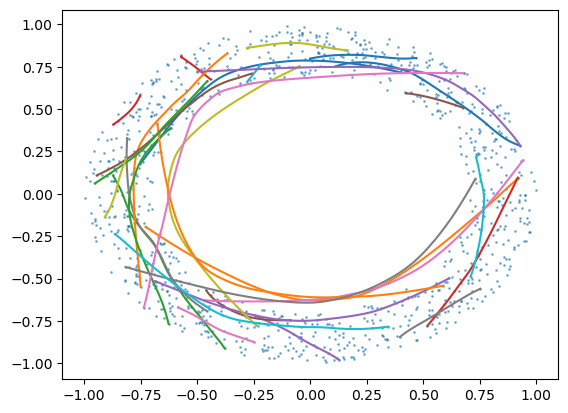

In [33]:
from stochman.geodesic import geodesic_minimizing_energy
from stochman import CubicSpline

plt.scatter(data[:, 0], data[:, 1], s=1, alpha=0.5)
batch_c = CubicSpline(begin=data[curve_indices[:, 0]], end=data[curve_indices[:, 1]], num_nodes=20)
geodesic_minimizing_energy(curve=batch_c, manifold=dm, optimizer=torch.optim.RMSprop, max_iter=200)
batch_c.plot()
plt.show()

In [31]:
batch_c.euclidean_length().mean().item()

1.0392897129058838

In [ ]:
# Function to embed 2D points into a 100D space with nonlinearity
def embed_points_2d_to_100d(points_2d):
    # Example non-linear transformations
    def nonlinear_map(x, y):
        features = []
        # Polynomial terms
        features.append(x)
        features.append(y)
        features.append(x**2)
        features.append(y**2)
        features.append(x * y)
        # Trigonometric terms
        features.append(np.sin(x))
        features.append(np.cos(y))
        features.append(np.sin(x * y))
        # More complex interactions
        features.append(np.sqrt(np.abs(x * y)))
        features.append(np.exp(-x**2 - y**2))
        # Expand to 100 dimensions by repeating patterns
        while len(features) < 100:
            features.append(features[len(features) % len(features)])  # Repeat patterns
        return np.array(features[:100])  # Truncate or pad to exactly 100 features

    # Apply the transformation to each 2D point
    points_100d = np.array([nonlinear_map(x, y) for x, y in points_2d])
    return points_100d